In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv
import scanpy as sc

In [2]:
multivelo = anndata.read_h5ad(
    '../data/Mouse_skin/multivelo_result.h5ad')
celldancer = anndata.read_h5ad(
    '../data/Mouse_skin/celldancer.h5ad')


In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.left'] = True

In [4]:

adata_out = anndata.read_h5ad(
    '../data/Mouse_skin/adata_out.moflow.h5ad')


In [5]:
multivelo.layers['Mc'] = multivelo.layers['ATAC']
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']

In [6]:
model = np.zeros(adata_out.n_vars).astype(str)
on_ = np.zeros(adata_out.n_vars)
off_ = np.zeros(adata_out.n_vars)
m1_ = np.zeros(adata_out.n_vars)
m2_ = np.zeros(adata_out.n_vars)

for i, g in enumerate(adata_out.var_names):
    c = adata_out[:, g].layers['c'].ravel()
    u = adata_out[:, g].layers['u'].ravel()
    s = adata_out[:, g].layers['s'].ravel()
    
    vc = adata_out[:, g].layers['velo_c'].ravel()
    vs = adata_out[:, g].layers['velo_s'].ravel()
    vu = adata_out[:, g].layers['velo_u'].ravel()
    
    w_non_zero = ((c >= 0.1 * np.max(c)) &
                    (u >= 0.1 * np.max(u)) &
                    (s >= 0.1 * np.max(s)))
    u_non_zero = u[w_non_zero]
    s_non_zero = s[w_non_zero]
    wu = u >= np.percentile(u_non_zero, 90)
    ws = s >= np.percentile(s_non_zero, 90)
    
    ww = wu|ws

    on_[i] = np.mean((vu[ww]>0)&(vs[ww]>0))
    off_[i] = np.mean((vu[ww]<0)&(vs[ww]<0))
    m1_[i] = np.mean((vc[ww]<0)&(vu[ww]>0))
    m2_[i] = np.mean((vc[ww]>0)&(vu[ww]<0))
    
    if (np.mean(vu[ww]>0) > .7) & (np.mean(vs[ww]>0) >.7):
        model[i] = 'on'
    elif (np.mean(vu[ww]<0) > 0.8) & (np.mean(vs[ww]<0)>.8):
        model[i] = 'off'
    else:
        if np.mean(vc[ww]>0) > 0.5:
            model[i] = 'm2'
        else:
            model[i] = 'm1'

In [11]:
temp = pd.DataFrame({'on': on_, 'off': off_,
                     'm1': m1_, 'm2': m2_,
                     'model': model},
                    index=adata_out.var_names)

In [7]:
adata_norma = adata_out.copy()
adata_norma.layers['alpha'] -= adata_norma.layers['alpha'].min(axis=0)
adata_norma.layers['alpha'] /= adata_norma.layers['alpha'].max(axis=0)

In [8]:
agg_c = sc.get.aggregate(adata_norma, by='celltype', axis=0, layer='c', func=['mean', 'var'])
agg_a = sc.get.aggregate(adata_norma, by='celltype', axis=0, layer='alpha', func=['mean', 'var'])

In [9]:
agg_df = pd.DataFrame({
          "c": np.std(agg_c.layers['mean'], axis=0),
          "a": np.std(agg_a.layers['mean'], axis=0)},
                      index=adata_out.var_names)

In [12]:
agg_df_ = agg_df[temp['model']!='off']

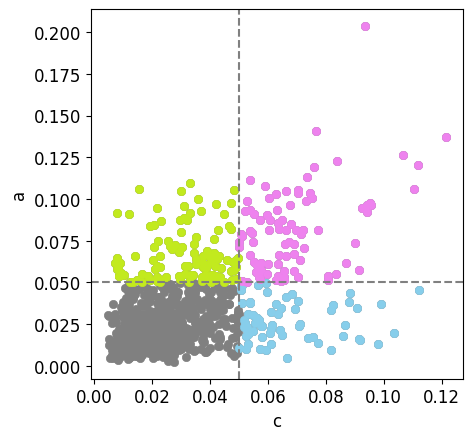

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4.8, 4.8))
sns.scatterplot(agg_df_, x='c', y='a', color='grey', edgecolor=None)
sns.scatterplot(agg_df_[(agg_df_['c']>=0.05)&(agg_df_['a']<0.05)], x='c', y='a', color='skyblue', edgecolor=None)
sns.scatterplot(agg_df_[(agg_df_['c']>=0.05)&(agg_df_['a']>=0.05)], x='c', y='a', color='violet', edgecolor=None)
sns.scatterplot(agg_df_[(agg_df_['c']<0.05)&(agg_df_['a']>=0.05)], x='c', y='a', color='#c2ea1e', edgecolor=None)
ax.axvline(0.05, color='grey', linestyle='--')
ax.axhline(0.05, color='grey', linestyle='--')
fig.savefig('../figures/fig5A_cate.pdf')

In [13]:
agg_df_upcase = agg_df_.copy()
agg_df_upcase.index = np.char.upper(agg_df_.index.values.astype('str'))

In [14]:
import gseapy as gp

In [16]:
gene_sets = 'GO_Biological_Process_2025'

In [17]:
gsea_res_a = gp.prerank(
    rnk = agg_df_upcase['a'],
    gene_sets=gene_sets,
    organism="Mouse",
    outdir=None
    
)
gsea_res_c = gp.prerank(
    rnk = agg_df_upcase['c'],
    gene_sets=gene_sets,
    organism="Mouse",
    outdir=None
    
)

In [20]:
ax = gp.dotplot(gsea_res_a.res2d, column="NOM p-val", top_term=10,
             figsize=(2.4,4.8), title='alpha',
             ofname='../figures/fig5A_S_gsea_alpha.pdf'
)

In [22]:
ax = gp.dotplot(gsea_res_c.res2d, column="NOM p-val", top_term=10,
             figsize=(2.4, 4.8), title='chromatin accessibility',
             ofname='../figures/fig5A_S_gsea_c.pdf'
)

In [32]:
res_a = gsea_res_a.res2d
res_a = res_a[res_a['NOM p-val']<=0.05]
res_a = res_a.sort_values(by='NES', ascending=False)

res_c = gsea_res_c.res2d
res_c = res_c[res_c['NOM p-val']<=0.05]
res_c = res_c.sort_values(by='NES', ascending=False)

In [33]:
set(res_a['Term']) & set(res_c['Term'])

{'Axon Guidance (GO:0007411)',
 'Negative Regulation of Cell Motility (GO:2000146)',
 'Neuron Projection Guidance (GO:0097485)',
 'Regulation of Cell Migration (GO:0030334)',
 'Regulation of Small GTPase Mediated Signal Transduction (GO:0051056)',
 'Regulation of Transcription by RNA Polymerase II (GO:0006357)'}

In [34]:
set(res_a['Term']) - set(res_c['Term'])

{'Axonogenesis (GO:0007409)',
 'Negative Regulation of Apoptotic Process (GO:0043066)',
 'Negative Regulation of DNA-templated Transcription (GO:0045892)',
 'Negative Regulation of Transcription by RNA Polymerase II (GO:0000122)',
 'Organelle Organization (GO:0006996)',
 'Positive Regulation of Cytokine Production (GO:0001819)',
 'Positive Regulation of MAPK Cascade (GO:0043410)',
 'Positive Regulation of Multicellular Organismal Process (GO:0051240)',
 'Positive Regulation of RNA Biosynthetic Process (GO:1902680)',
 'Positive Regulation of Signal Transduction (GO:0009967)',
 'Positive Regulation of Transcription by RNA Polymerase II (GO:0045944)',
 'Regulation of Cell Differentiation (GO:0045595)',
 'Regulation of Intracellular Signal Transduction (GO:1902531)'}

In [35]:
set(res_c['Term']) - set(res_a['Term'])

{'Epithelial Cell Differentiation (GO:0030855)',
 'Epithelium Development (GO:0060429)',
 'Intracellular Signaling Cassette (GO:0141124)',
 'Positive Regulation of Cell Differentiation (GO:0045597)',
 'Positive Regulation of Cell Migration (GO:0030335)',
 'Positive Regulation of Cell Motility (GO:2000147)',
 'Positive Regulation of Cell Population Proliferation (GO:0008284)',
 'Positive Regulation of Cellular Process (GO:0048522)',
 'Positive Regulation of Intracellular Signal Transduction (GO:1902533)',
 'Regulation of Angiogenesis (GO:0045765)',
 'Regulation of DNA-templated Transcription (GO:0006355)',
 'Regulation of Phosphatidylinositol 3-Kinase/Protein Kinase B Signal Transduction (GO:0051896)',
 'Supramolecular Fiber Organization (GO:0097435)'}

In [12]:
hcha = pd.read_csv('../temps/hcha.txt', sep='\t')
hcla = pd.read_csv('../temps/hcla.txt', sep='\t')
lcha = pd.read_csv('../temps/lcha.txt', sep='\t')

In [13]:
import matplotlib as mpl
from matplotlib import cm

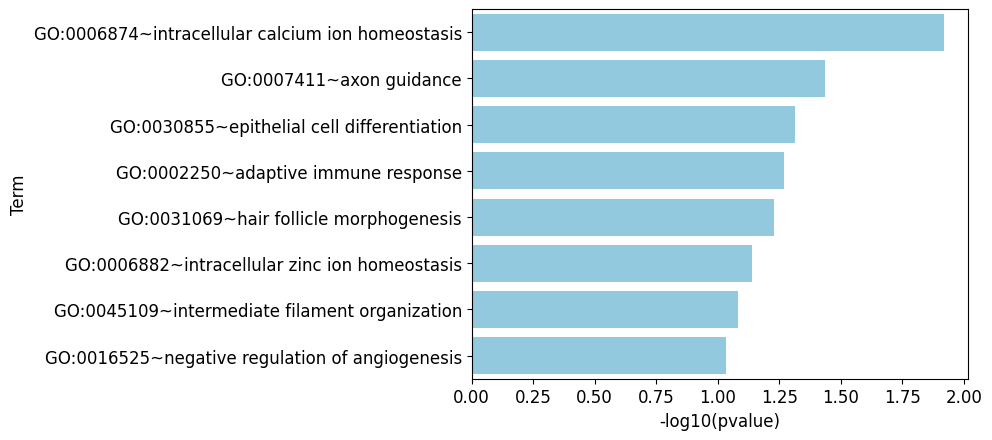

In [17]:
def plot(df, color, x='FDR', barcolor='grey', head=20):
    #df = df[df[x]<=0.5].
    df= df.sort_values(by=x)
    df['-log10(pvalue)'] = -np.log10(df[x])
    
    norm = mpl.colors.Normalize(vmax = df.head(20)[color].max(),
                                vmin = df.head(20)[color].min())
    mapper = cm.ScalarMappable(norm = norm, cmap = cm.viridis)
 
    sns.barplot(x=df.head(head)['-log10(pvalue)'],
            y=df.head(head)['Term'][::-1],
       color=barcolor)
plot(hcla, 'Count', 'PValue', 'skyblue')
plt.savefig('../figures/fig5B_S_GO_hcla.pdf')

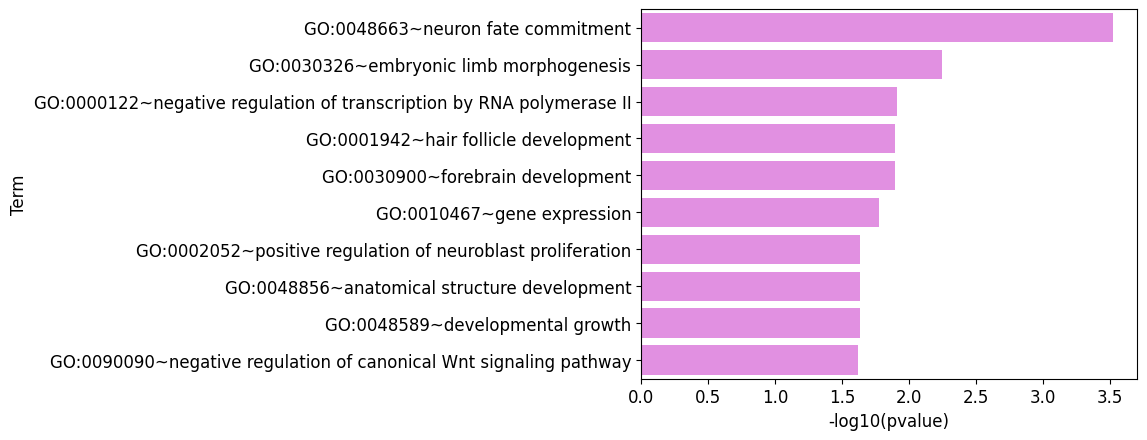

In [18]:
plot(hcha, 'Count', 'PValue', 'violet', 10)
plt.savefig('../figures/fig5B_S_GO_hcha.pdf')


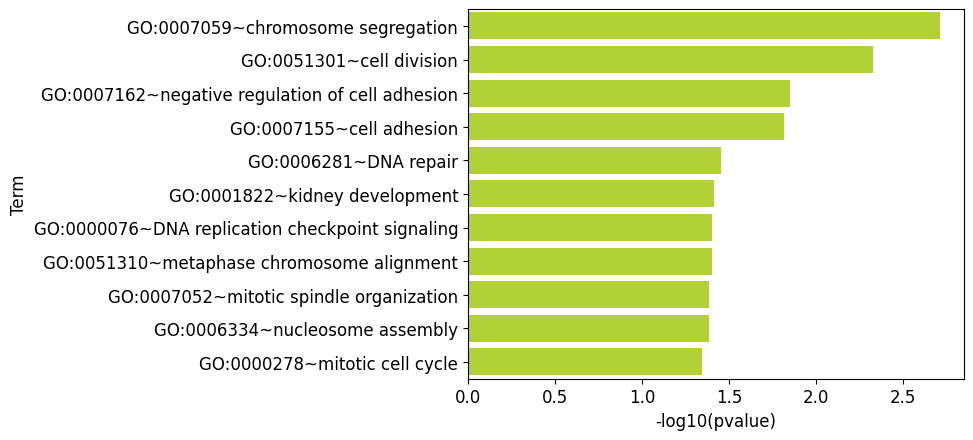

In [22]:
plot(lcha, 'Count', 'PValue', '#c2ea1e', 11)
plt.savefig('../figures/fig5B_GO_lcha.pdf')

In [23]:
hc_ha = agg_df_[(agg_df_['c']>=0.05) & (agg_df_['a']>=0.05)]
hc_la = agg_df_[(agg_df_['c']>=0.05) & (agg_df_['a']<0.05)]
lc_ha = agg_df_[(agg_df_['c']<0.05) & (agg_df_['a']>=0.05)]
lc_la = agg_df_[(agg_df_['c']<0.05) & (agg_df_['a']<0.05)]

In [24]:
hc_ha

,c,a
1700025G04Rik,0.062857,0.102975
Aak1,0.070370,0.053339
Apbb2,0.064608,0.050748
Arhgap29,0.094142,0.096662
Arhgef10l,0.080657,0.051621
...,...,...
Utrn,0.067721,0.096446
Vav3,0.073028,0.098498
Wdr47,0.051232,0.050851
Zfp750,0.095702,0.096119


In [25]:
scv.tl.score_genes_cell_cycle(adata_out)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


In [26]:
g2m_results = []
s_results = []
group = []

import scipy.stats as stats
for gene in agg_df_.index:
    tempdf = agg_df_.loc[gene]
    if  tempdf['c']>=0.05:
        if tempdf['a']<0.05:
            group.append('hcla')
        else:
            group.append('hcha')
    else:
        if tempdf['a']<0.05:
            group.append('lcla')
        else:
            group.append('lcha')

    gene_expr = adata_out[:, gene].X.toarray().flatten()

    s_score = adata_out.obs["S_score"]
    low_s = gene_expr[s_score <= 0]
    high_s = gene_expr[s_score > 0]

    t_stat, p_val_t = stats.ttest_ind(low_s, high_s, equal_var=False)

    u_stat, p_val_u = stats.mannwhitneyu(low_s, high_s, alternative="two-sided")

    s_results.append({
        "Gene": gene,
        "Mean_Low_S": np.mean(low_s),
        "Mean_High_S": np.mean(high_s),
        "T-test p-value": p_val_t,
        "Mann-Whitney p-value": p_val_u
    })
    
    g2m_score = adata_out.obs["G2M_score"]
    low_s = gene_expr[s_score <= 0]
    high_s = gene_expr[s_score > 0]

    t_stat, p_val_t = stats.ttest_ind(low_s, high_s, equal_var=False)

    u_stat, p_val_u = stats.mannwhitneyu(low_s, high_s, alternative="two-sided")

    g2m_results.append({
        "Gene": gene,
        "Mean_Low_S": np.mean(low_s),
        "Mean_High_S": np.mean(high_s),
        "T-test p-value": p_val_t,
        "Mann-Whitney p-value": p_val_u
    })
    
    
g2mscore_result = pd.DataFrame(g2m_results)
sscore_result = pd.DataFrame(s_results)

In [37]:
g2mscore_result_ = g2mscore_result.set_index('Gene')
g2mscore_result_['c'] = agg_df_['c']
g2mscore_result_['a'] = agg_df_['a']

In [45]:
sscore_result_ = sscore_result.set_index('Gene')
sscore_result_['c'] = agg_df_['c']
sscore_result_['a'] = agg_df_['a']

In [39]:
g2mscore_result_['group'] = group
g2mscore_result_['-log10(p-val)'] = -np.log10(g2mscore_result_['Mann-Whitney p-value'])

In [50]:
sscore_result_['group'] = group
sscore_result_['-log10(p-val)'] = -np.log10(sscore_result_['Mann-Whitney p-value'])

In [51]:
sscore_result_

,Mean_Low_S,Mean_High_S,T-test p-value,Mann-Whitney p-value,c,a,group,-log10(p-val)
Gene,,,,,,,,
1700025G04Rik,-0.019393,0.028209,0.070218,0.113531,0.062857,0.102975,hcha,0.944887
2610507B11Rik,0.002680,-0.003898,0.795480,0.568942,0.020437,0.022993,lcla,0.244932
4833420G17Rik,0.004994,-0.007264,0.627430,0.591976,0.011993,0.010137,lcla,0.227696
5031439G07Rik,0.023790,-0.034606,0.016850,0.000969,0.103398,0.019783,hcla,3.013514
9930021J03Rik,0.001071,-0.001558,0.917444,0.521182,0.011294,0.014748,lcla,0.283011
...,...,...,...,...,...,...,...,...
Znhit6,0.004620,-0.006721,0.653566,0.616852,0.021518,0.023099,lcla,0.209819
Znrf1,-0.005055,0.007352,0.634205,0.811315,0.065618,0.051269,hcha,0.090811
Zranb3,-0.026424,0.038437,0.016230,0.007910,0.012214,0.010384,lcla,2.101834


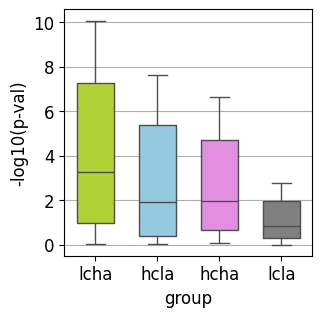

In [58]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(g2mscore_result_, y='-log10(p-val)', 
            x='group', fill=True, order=['lcha', 'hcla', 'hcha', 'lcla'],
            palette=['#c2ea1e','skyblue','violet', 'grey'],
            showfliers=False, width=.6, whis=.5, 
            
)
ax.grid(axis='y')
fig.savefig('../figures/fig5C_g2mscore.pdf')

<Axes: xlabel='group', ylabel='-log10(p-val)'>

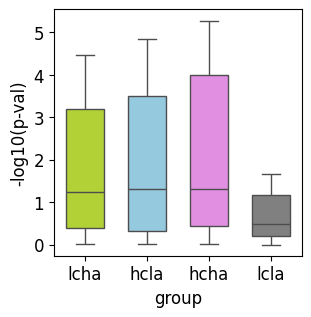

In [54]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(sscore_result_, y='-log10(p-val)', 
            x='group', fill=True, order=['lcha', 'hcla', 'hcha', 'lcla'],
            palette=['#c2ea1e','skyblue','violet', 'grey'],
            showfliers=False, width=.6, whis=.5, 
            
)

In [28]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [29]:
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']
multivelo.layers['Mc'] = multivelo.layers['ATAC']

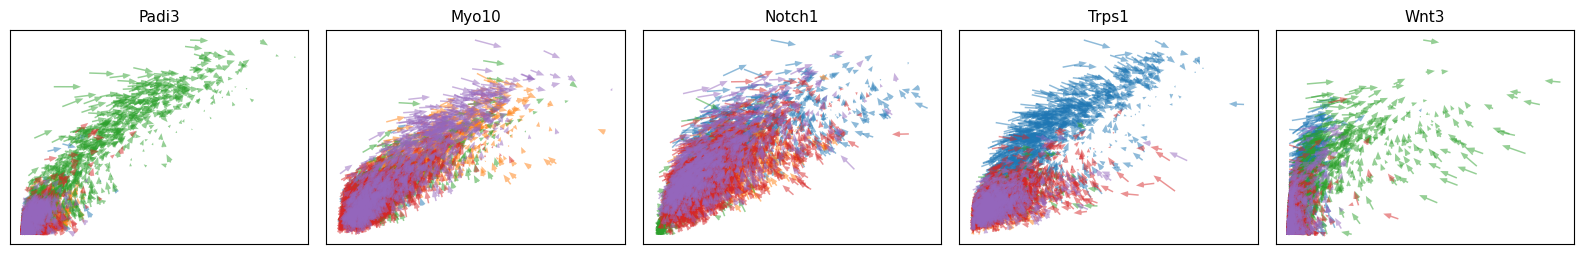

In [37]:
fig, ax = mf.scatter_gene(adata_out,['Padi3', 'Myo10', 'Notch1', 'Trps1', 'Wnt3'],  velocity_arrows=True, color_by='celltype',clim=(-1,1),
                          axis_on=False)

fig.savefig('../figures/fig5C_moflow.pdf')

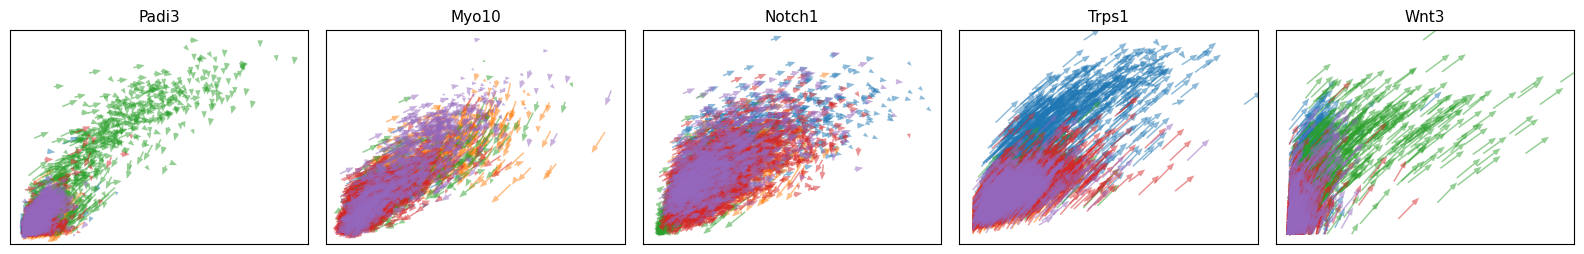

In [38]:
fig, ax = mf.scatter_gene(multivelo, ['Padi3', 'Myo10', 'Notch1', 'Trps1', 'Wnt3' ],  velocity_arrows=True,
                          axis_on=False)
for a in ax[0]:
    a.set_xticks([])
    a.set_yticks([])
fig.savefig('../figures/fig5C_multivelo.pdf')

In [33]:
celldancer.layers['Mc'] = np.ones_like(celldancer.layers['Mu'])
celldancer.layers['velo_c'] = np.zeros_like(celldancer.layers['Mu'])

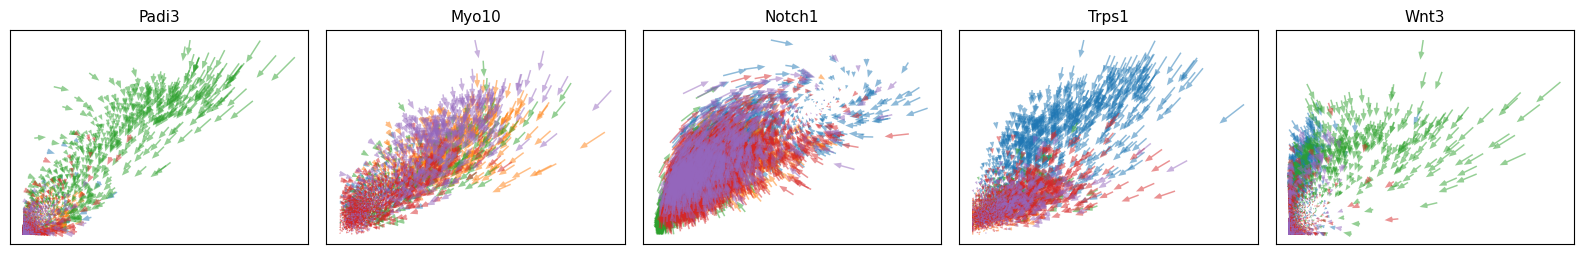

In [39]:
fig, ax = mf.scatter_gene(celldancer, 
                          ['Padi3', 'Myo10', 'Notch1', 'Trps1', 'Wnt3' ], velocity_arrows=True,
                          axis_on=False)
for a in ax[0]:
    a.set_xticks([])
    a.set_yticks([])
fig.savefig('../figures/fig5C_celldancer.pdf')

In [41]:
adata_out.obs['celltype'] = pd.Categorical(adata_out.obs['celltype'],
                                           ['TAC-1', 'TAC-2', 'Hair Shaft-cuticle.cortex', 'IRS', 'Medulla', ])
adata_out.uns['celltype_colors'] = ['#d62728', '#9467bd','#1f77b4', '#ff7f0e', '#2ca02c', ]

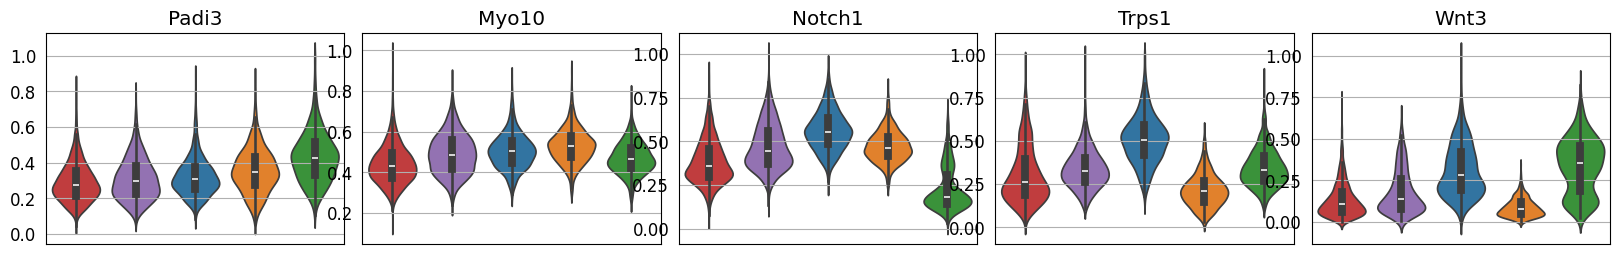

In [46]:
fig, axes = mf.gene.violinplot(adata_out, 
                               ['Padi3', 'Myo10', 'Notch1', 'Trps1', 'Wnt3'], by='c',
                               axis_on=False)
for ax in axes[0]:
    ax.get_yaxis().set_visible(True)
    ax.grid(axis='y') 
    ax.set_ylabel('')
fig.savefig('../figures/fig5C_c.pdf')

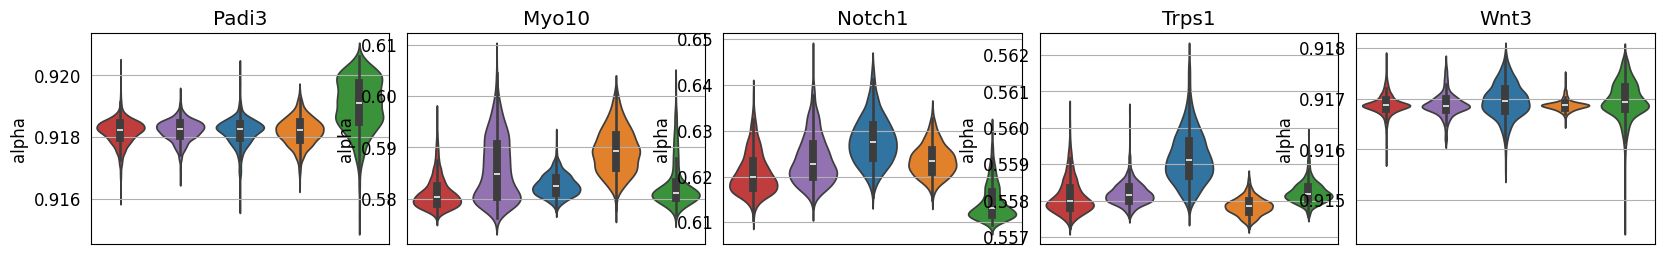

In [43]:
fig, axes = mf.gene.violinplot(adata_out, 
                               ['Padi3', 'Myo10', 'Notch1', 'Trps1', 'Wnt3'], by='alpha',
                               axis_on=False)
for ax in axes[0]:
    ax.get_yaxis().set_visible(True)
    ax.grid(axis='y') 
fig.savefig('../figures/fig5C_alpha.pdf')